# Metropolis-Hastings
Accomadating notebook to reproduce the experiments from the Bachelor's Thesis 'The Metropolis-Hastings algorithm for large datasets' from Fynn Orth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import time
from scipy.stats import norm

## Useful functions

In [2]:
#Scrapped
def sample_quality_score(sample, true_theta):
    '''Computes the quality score of a sample given the true theta'''
    # Compute the mean of the sample

    sample_mean = np.mean(sample, axis=0)
    mean_score = npl.norm(sample_mean - true_theta)

    sample_variance = np.std(sample)


    return mean_score, sample_variance

In [3]:
#This function implements the subsampling methods used for the samples produced by MH
def create_sample(data, b, c):
    # Discard the first b of elements (burn-in)
    data = data[b:]

    # Select every c datapoint (gap length)
    data = data[::c]

    return data

# Function to clean up acceptance probabilties
def clean_acceptance_probability(array):
    # Replace values bigger than 1 with 1
    array = np.where(array > 1, 1, array)
    return array

In [4]:
def bernoulli_sampling(data, sampling_perc):
    subsample_indx = npr.binomial(n=1,p=sampling_perc, size=data.size)
    subsample = data[subsample_indx == 1]
    return subsample

#Test
#array = np.arange(10000)
#test = bernoulli_sampling(array, 0.5)
#print(test)
#print(test.size)

### Plotting

In [70]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

def plt_samples(dataset, filename = None):
    '''Plots the samples in a jointplot'''

    # Create a jointplot with smaller hexagons and aligned outlines
    g = sns.jointplot(x=dataset[:, 0], y=dataset[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')

    # Remove the spines of the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    if filename:
        plt.savefig(f"Plots/samples_{filename}.png")

    # Show the plot
    plt.show()
    return g
#Test plotting
#dataset1 = npr.normal(size=(10000, 2))
#dataset2 = npr.normal(size=(100000,2))
#fig1 = sns.jointplot(x=dataset1[:, 0], y=dataset1[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')
#fig1.savefig('Plots/fig1.png')

def plot_accepted(data, window_size, filename = None):
    '''Plots the running average of a given array over a window of w iterations'''
    running_avg = np.convolve(data, np.ones(window_size), 'valid') / window_size
    plt.plot(running_avg)
    plt.xlabel('Iteration')
    plt.ylabel('Running Average of Accepted ')

    if filename:
        plt.savefig(f"Plots/samples_{filename}.png")
    plt.show()

def plot_lkhd(data, filename = None):
    plt.plot(data)
    plt.xscale("log")
    plt.xlabel('Iteration (Logarithmic scale)')
    plt.ylabel('Log-Likelihood Function Evaluation')

    if filename:
        plt.savefig(f"Plots/samples_{filename}.png")
    plt.show()


## Likelihood Functions

In [6]:
#Likelihood Function for the Standard Normal Model
class Std_log_lkhd():

    def comp_func(self,data, theta):
        '''Return log_likelihood of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        log_lkhd = np.mean(-((data - mu) ** 2) / (2 * sigma**2) - np.log(sigma))
        return log_lkhd

    def comp_grad(self, data, theta):
        '''Return gradient of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        grad_mu = np.mean((data - mu) / sigma**2)
        grad_sigma = np.mean(((data - mu) ** 2) / sigma**3) - 1/sigma
        grad = np.array([grad_mu, grad_sigma])
        return grad

    #Scrapped because FlyMC Scrapped
    def comp_hess(self, data, theta):
        '''Return hessian of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        hess_mu_mu = np.ones(data.size)*(-1)/sigma**2
        hess_mu_sig = (-2)*(data - mu)/sigma**3
        hess_sig_sig = (-3)*((data - mu) ** 2) / sigma**4 + 1/sigma**2
        hess = np.array([[hess_mu_mu, hess_mu_sig], [hess_mu_sig, hess_sig_sig]])
        return hess

    #Scrapped because FLYMC scrapped
    def comp_third_deriv(self, data, theta):
        mu = theta[0]
        sigma = theta[0]
        td_mu_mu_mu = np.zeros(data.size)
        td_mu_mu_sig = np.ones(data.size)*2/sigma**3
        td_mu_sig_sig = (6)*(data - mu)/sigma**4
        td_sig_sig_sig = (12)*((data - mu) ** 2) / sigma**5 - 2/sigma**3
        third_deriv = np.array([td_mu_mu_mu, td_mu_mu_sig, td_mu_sig_sig, td_sig_sig_sig])
        return  third_deriv

    #Scrapped because FLYMC scrapped
    def comp_log_bound_func(self, data, current_theta, proposal_theta, MAPs):
        thetaMAP = MAPs[0]
        lkhd_MAP = MAPs[1]
        grad_MAP = MAPs[2]
        hess_MAP = MAPs[3]
        h = current_theta - thetaMAP
        grad = np.dot(grad_MAP.T,h)
        hess = np.dot(np.dot(hess_MAP, h), h)
        #Compute min and max of data
        min_data = np.min(data)
        max_data = np.max(data)
        xMinusMuMax = np.max(np.abs([1, min_data - current_theta[0],max_data - current_theta[0], min_data - thetaMAP[0], max_data - thetaMAP[0], max_data - proposal_theta[0], min_data - proposal_theta[0]]))
        sigmaMin = min(current_theta[1], thetaMAP[1], proposal_theta[1])
        M = np.max(np.abs(self.comp_third_deriv(data, np.array([xMinusMuMax, sigmaMin]))))
        R = M/6*npl.norm(h)**2
        logB = lkhd_MAP + grad + hess + R
        return logB


In [7]:
class Bimodal_log_lkhd():

    def comp_func(self, data, theta):
            mu_1 = theta[0]
            mu_2 = theta[1]
            p = 0.5
            lkhd_mu1 = np.exp((-((data - mu_1) ** 2)) / 2)
            lkhd_mu2 = np.exp((-((data - mu_2) ** 2)) / 2)
            log_lkhd = np.mean(np.log(p * lkhd_mu1 + (1 - p) * lkhd_mu2))
            return log_lkhd

    def comp_grad(self, data, theta):
        mu_1 = theta[0]
        mu_2 = theta[1]
        p = 0.5
        denominator = (p * np.exp(-((data - mu_1) ** 2) / 2) + (1 - p) * np.exp(-((data - mu_2) ** 2) / 2))
        grad_mu1 = np.mean(p*(data - mu_1)*np.exp(-((data - mu_1) ** 2) / 2) / denominator)
        grad_mu2 = np.mean((1-p)*(data - mu_2)*np.exp(-((data - mu_2) ** 2) / 2) / denominator)
        grad = np.array([grad_mu1, grad_mu2])
        return grad

#Test the likelihood function
#test_norm = Normal_param_loglkhd()
#data = np.array([1, 2, 3, 4, 5])
#print(test_norm.comp_func(data, np.array([0,1])))

## Proposal functions

In [8]:
# This cell implements all proposal functions
class Proposer():

    def grw_propose(self, theta, stepsize):
        '''Propose a new sample using a Gaussian random walk proposal'''
        proposal = npr.normal(theta, stepsize, len(theta))
        return proposal

    def langevin_propose(self, theta, grad, stepsize, gradient_scaler):
        '''Propose a new sample using a Langevin proposal'''
        proposal = npr.normal(theta + grad * gradient_scaler, stepsize, len(theta))
        return proposal

## Datasets

In [9]:
npr.seed(1)
N = 10**5 # Number of data points

# Std dataset
mu = 0
sigma = 1
std_dataset = npr.normal(mu, sigma, N)
realMean = np.mean(std_dataset)
realStd = np.std(std_dataset)
std_MAP = np.array([realMean, realStd])
#plt.hist(normal_param_data, bins=100)

# Bimodal dataset
p =1/2
p_actual = npr.binomial(N, p)
print(p_actual)
mu1 = 0
mu2 = 1
mu1_normal = npr.normal(mu1, 1, p_actual)
mu2_normal = npr.normal(mu2, 1, N - p_actual)
bimodal_dataset = np.concatenate((mu1_normal, mu2_normal))
npr.shuffle(bimodal_dataset)
#plt.hist(bimodal_data, bins=100)


50114


# Algorithm Implementation and Testing

## RWMH

In [10]:
def RWMH(data, lkhd_function, initial_theta, num_iterations, stepsize, lkhd_scaler = 1):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    lkhd_diff = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    lkhd = np.empty(num_iterations)
    lkhd[0] = lkhd_scaler * lkhd_function.comp_func(data, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = Proposer().grw_propose(samples[i], stepsize)

        # Compute the acceptance probability
        lkhd_proposal = lkhd_scaler * lkhd_function.comp_func(data, proposal)
        lkhd_diff[i] = lkhd_proposal - lkhd[i]
        acceptence_prob[i] = np.exp(lkhd_diff[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff

In [11]:
# RWMH
# Parameters
data = std_dataset
#data = bimodal_data
lkhd = Std_log_lkhd()
#lkhd = Bimodal_norm_param_loglkhd()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.01
lkhd_scaler = 10000

samples, accepted, acceptence_prob, lkhd, lkhd_diff = RWMH(data, lkhd, initial_theta, num_iterations, stepsize, lkhd_scaler)
print("SUCCESFULLY RAN RWMH")

SUCCESFULLY RAN RWMH


(7.001052659584623, 0.4969384802950631)


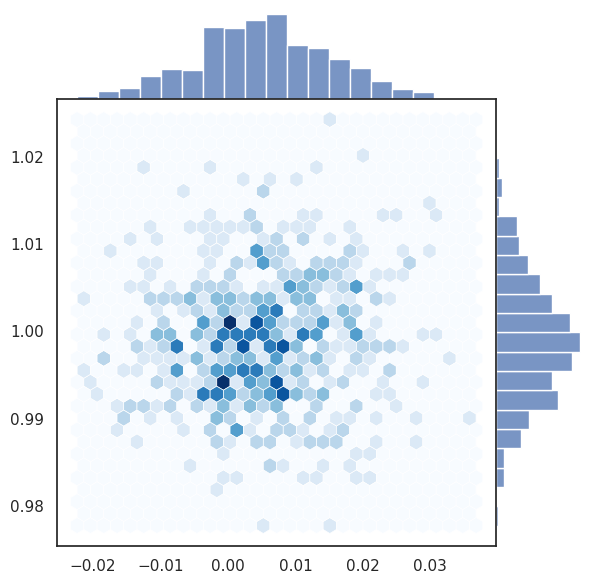

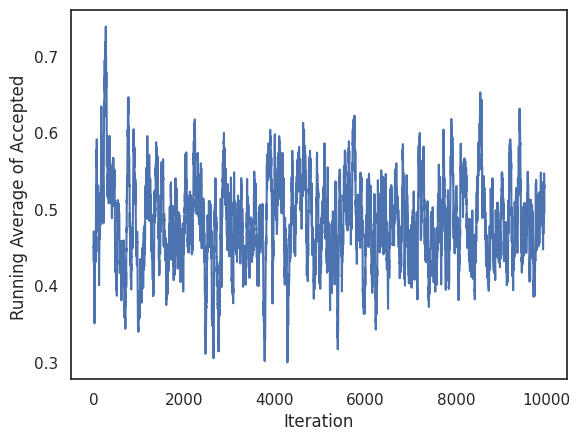

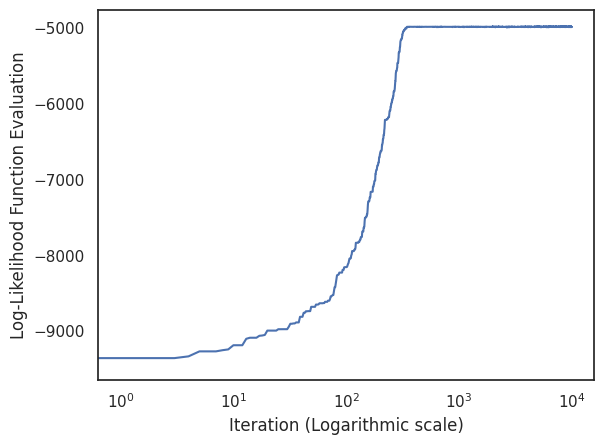

In [12]:
plot_samples = create_sample(samples, 4000,10)
print(sample_quality_score(plot_samples, np.array([0,8])
                           ))

plt_samples(plot_samples)
acceptence_prob = clean_acceptance_probability(acceptence_prob)
plot_accepted(acceptence_prob, 50)
plot_lkhd(lkhd)

## MALA

In [13]:
def mala(data, lkhd_function, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    #Compute initial values
    samples[0] = initial_theta
    lkhd[0] = lkhd_function.comp_func(data, initial_theta)
    grad[0] = lkhd_function.comp_grad(data, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = Proposer().langevin_propose(samples[i], grad[i], stepsize, gradient_scaler)

        # Compute the acceptance probability
        lkhd_proposal = lkhd_function.comp_func(data, proposal)
        grad_proposal = lkhd_function.comp_grad(data, proposal)
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff = (lkhd_proposal - lkhd[i])*lkhd_scaler
        acceptence_prob[i] = np.exp(lkhd_diff + (diff_old - diff_new) / (2*stepsize))

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd


In [14]:
# MALA
# Parameters
data = bimodal_dataset
lkhd = Bimodal_log_lkhd()
initial_theta = np.array([0.5,0.5])
num_iterations = 10**4
stepsize = 1
gradient_scaler = 0.1
lkhd_scaler = 10

samples, accepted, acceptence_prob, lkhd = mala(data, lkhd, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler)
print("SUCCESFULLY RAN MALA")

SUCCESFULLY RAN MALA


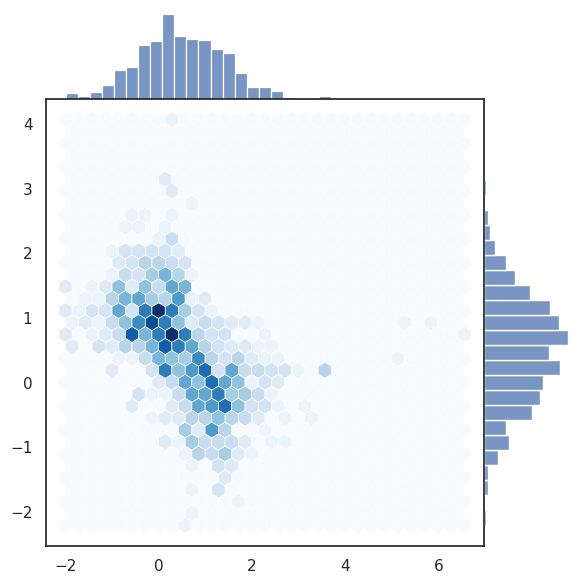

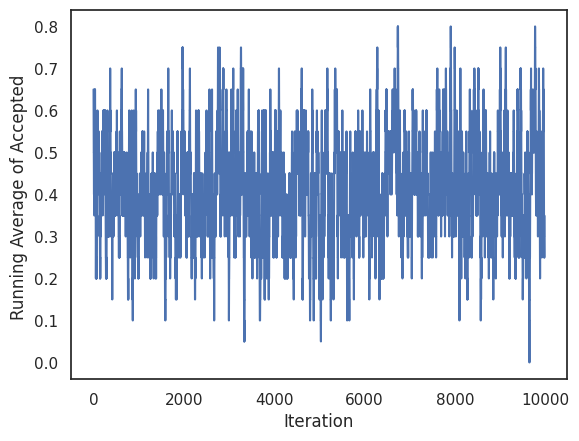

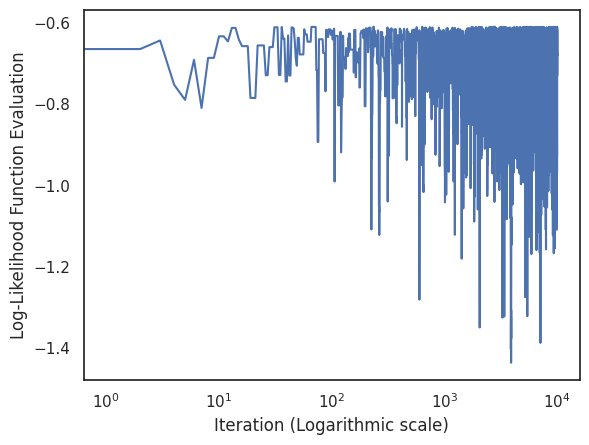

In [15]:
plot_samples = create_sample(samples, 1000,10)

plt_samples(plot_samples)
plot_accepted(accepted, 20)
plot_lkhd(lkhd)

## consensusMC

In [16]:
#Useful functions for consensusMC
def batch_divider(data, num_batches):
    '''Divide the data into random batches'''
    batch_size = data.size // num_batches  # Calculate batch size
    indices = npr.permutation(data.size) # Create shuffled indices
    batches = [indices[i*batch_size:(i+1)*batch_size] for i in range(num_batches)] # Split shuffled indices into batches
    batches_data = [data[batch] for batch in batches] # Extract batches from batches using shuffled indices
    return batches_data

#Test
#data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#test = batch_divider(data, 3)
#print(test)

def batch_combiner(batch_sample_list):
    '''Combine the samples from the batches'''
    variance_list = [np.var(batch_sample) for batch_sample in batch_sample_list]
    sum_variances = np.sum(variance_list)
    weights = [variance / sum_variances for variance in variance_list]
    combined_samples = np.sum([weights[i] * batch_sample_list[i] for i in range(len(batch_sample_list))], axis=0)
    return combined_samples

#Test
#batch1 = np.array([[1, 2], [3, 4], [5,6]])
#batch2 = np.array([[6, 7], [8, 9], [10,11]])
#batch_sample_list = [batch1, batch2, batch2]
#test = batch_combiner(batch_sample_list)
#print(test)

In [17]:
def consensusMC(data, lkhd_function, initial_theta, num_iterations, stepsize, num_batches, lkhd_scaler = 1):
    batches = batch_divider(data, num_batches)
    args = [(batch, lkhd_function, initial_theta, num_iterations, stepsize, lkhd_scaler) for batch in batches] # List of arguments to run MH in parallel
    batch_list = []
    batch_sample_list = []
    for i in range(num_batches): # Parallel enviorenment
        #TODO: Make it parallel, save other returns from vanillaMH
        batch_list.append(RWMH(*args[i])) # Run MH
        batch_sample_list.append(batch_list[i][0])
        if i==0:
            samples, accepted, acceptence_prob, lkhd, lkhd_diff = RWMH(*args[i])

    sample = batch_combiner(batch_sample_list) # Combine samples returned by batches
    return sample, accepted, acceptence_prob, lkhd, lkhd_diff

In [18]:
# consensusMC
# Parameters
data = std_dataset
lkhd = Std_log_lkhd()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.1
num_batches = 1
lkhd_scaler = 500

samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data, lkhd, initial_theta, num_iterations, stepsize, num_batches, lkhd_scaler)
print("SUCCESFULLY RAN consensusMC")

SUCCESFULLY RAN consensusMC


(0.006118208302705559, 0.5002636574548566)


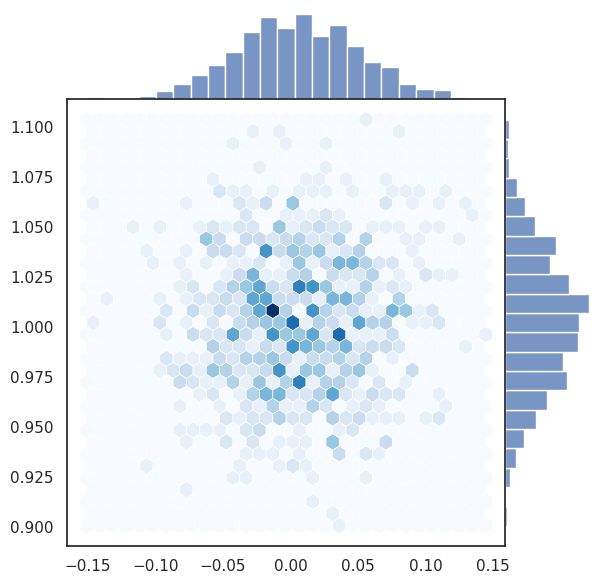

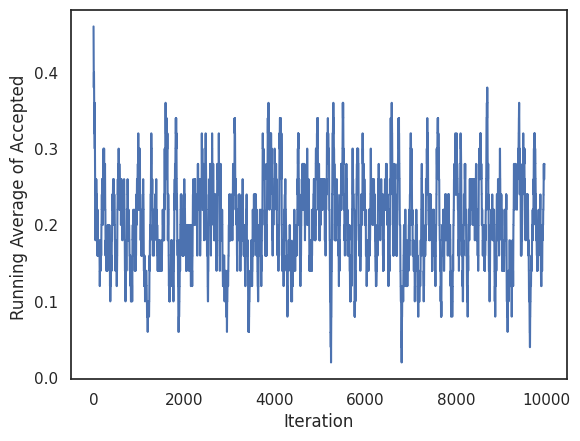

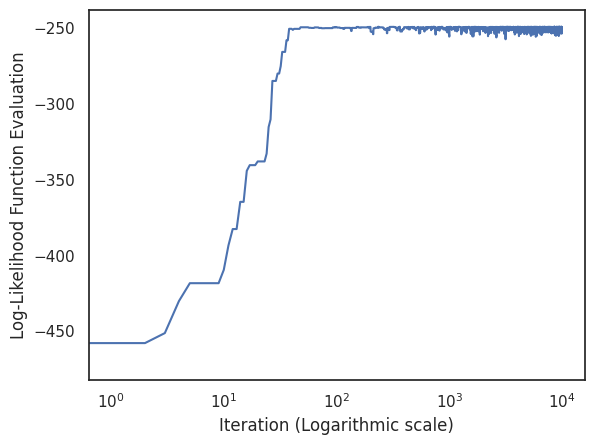

In [19]:
plot_samples = create_sample(samples, 1000,10)
print(sample_quality_score(plot_samples, np.array([0,1])))

plt_samples(plot_samples)

plot_accepted(accepted, 50)
plot_lkhd(lkhd)


## PMMH

In [20]:
def PMMH(data, lkhd_function, initial_theta, num_iterations, stepsize, lkhd_scaler, subsampling_perc):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    lkhd_diff = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    subsample = bernoulli_sampling(data, subsampling_perc)
    lkhd = np.empty(num_iterations)
    lkhd[0] = lkhd_scaler * lkhd_function.comp_func(subsample, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = Proposer().grw_propose(samples[i], stepsize)

        # Compute the acceptance probability
        subsample = bernoulli_sampling(data, subsampling_perc)
        lkhd_proposal = lkhd_scaler * lkhd_function.comp_func(subsample, proposal)
        lkhd_diff[i] = lkhd_proposal - lkhd[i]
        acceptence_prob[i] = np.exp(lkhd_diff[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff

In [21]:
# PMMH
# Parameters
data = std_dataset
#data = bimodal_data
lkhd = Std_log_lkhd()
#lkhd = Bimodal_norm_param_loglkhd()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.01
lkhd_scaler = 1000
subsampling_perc = 0.1

samples, accepted, acceptence_prob, lkhd, lkhd_diff = PMMH(data, lkhd, initial_theta, num_iterations, stepsize, lkhd_scaler, subsampling_perc)
print("SUCCESFULLY RAN PMMH")

SUCCESFULLY RAN PMMH


(6.975879960381711, 0.43158024440956155)


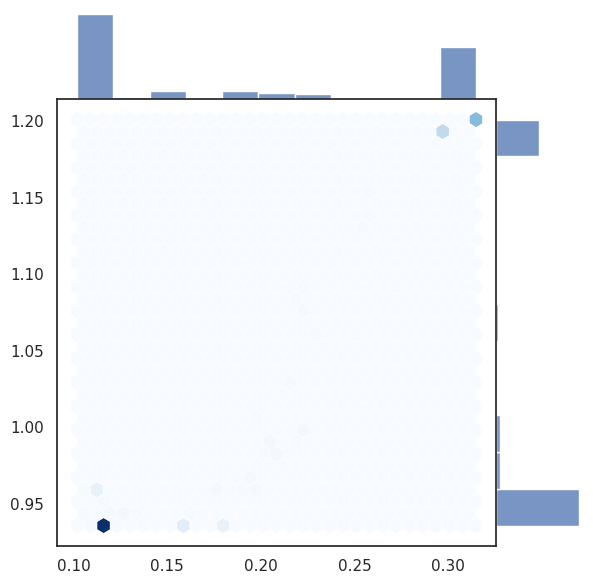

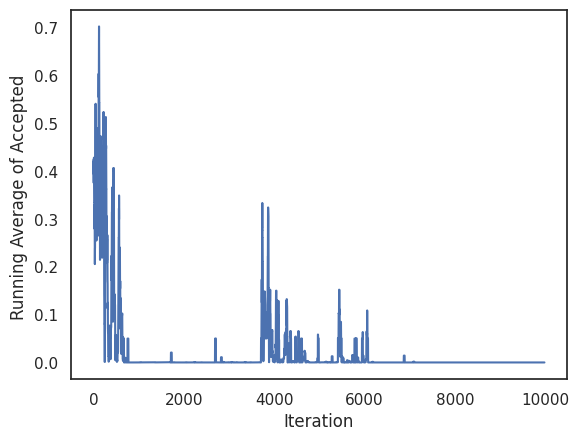

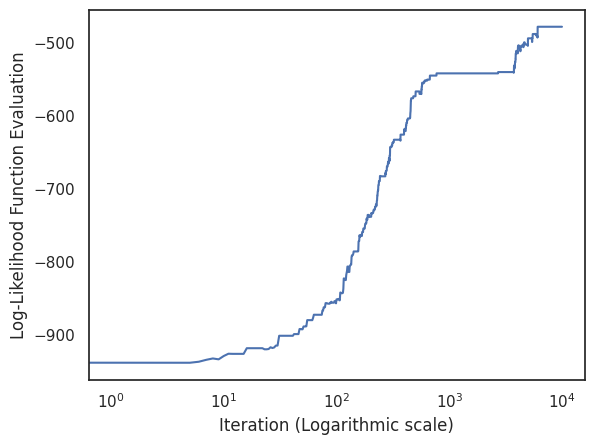

In [22]:
plot_samples = create_sample(samples, 1000,10)
print(sample_quality_score(plot_samples, np.array([0,8])
                           ))

plt_samples(plot_samples)
acceptence_prob = clean_acceptance_probability(acceptence_prob)
plot_accepted(acceptence_prob, 20)
plot_lkhd(lkhd)

## csMALA

In [23]:
def csMALA(data, lkhd_function, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd_diff = np.empty(num_iterations- 1)
    corr_diff = np.empty(num_iterations- 1)
    prob_diff = np.empty(num_iterations- 1)
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    correction_term = np.empty(num_iterations)
    log_subsampling_perc = np.log(subsampling_perc)
    #Compute initial values
    subsample = bernoulli_sampling(data, subsampling_perc)
    correction_term[0] = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
    samples[0] = initial_theta
    lkhd[0] = lkhd_function.comp_func(subsample, initial_theta)
    grad[0] = lkhd_function.comp_grad(subsample, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = Proposer().langevin_propose(samples[i],grad[i], stepsize, gradient_scaler)
        #New subsample
        subsample = bernoulli_sampling(data, subsampling_perc)
        # Compute the acceptance probability
        correction_term_proposal = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
        lkhd_proposal = lkhd_function.comp_func(subsample, proposal)
        grad_proposal = lkhd_function.comp_grad(subsample, proposal)
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff[i] = (lkhd_proposal - lkhd[i])*lkhd_scaler
        corr_diff[i] = correction_term_proposal - correction_term[i]
        prob_diff[i] = (diff_old - diff_new) / (2*stepsize)
        acceptence_prob[i] = np.exp(lkhd_diff[i] + corr_diff[i] + prob_diff[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            correction_term[i+1] = correction_term_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            correction_term[i+1] = correction_term[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff

In [24]:
# csMALA
# Parameters
data = std_dataset
lkhd = Std_log_lkhd()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.1
gradient_scaler = 0.1
subsampling_perc = 0.01
correction_scaler = 0.1
lkhd_scaler = 100

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data, lkhd, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler,lkhd_scaler)
print("SUCCESFULLY RAN csMALA")

SUCCESFULLY RAN csMALA


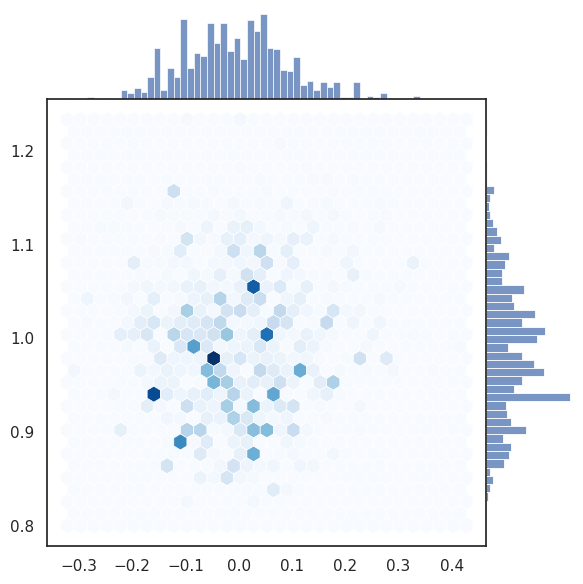

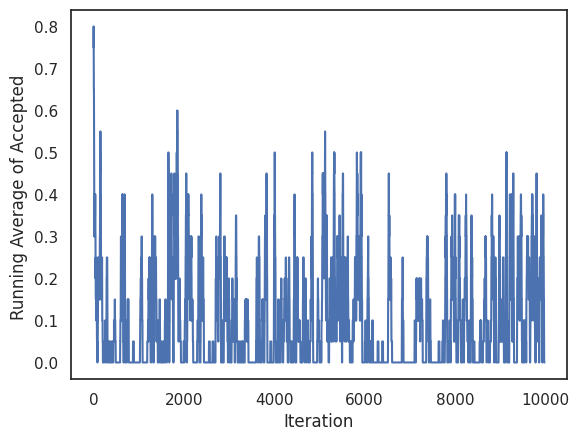

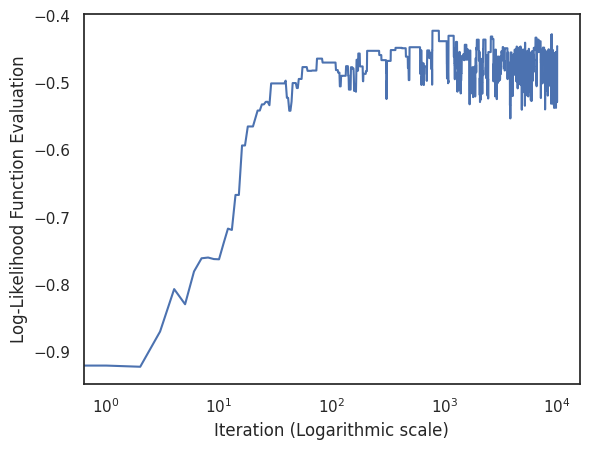

In [25]:
plot_samples = create_sample(samples, 1000,1)

plt_samples(plot_samples)
plot_accepted(accepted, 20)
plot_lkhd(lkhd)

## FireflyMC (Scrapped)

In [26]:
#Scrapped
'''def firefly_sampler(data, current, lkhd_function, standard_subsampling_perc, MAPs):
    z = bernoulli_sampling(data, standard_subsampling_perc)
    logL = np.mean(lkhd_function.comp_func(z, current))
    logB = lkhd_function.comp_log_bound_func(z, current, MAPs)
    adaptive_subsampling_perc = 1 - np.exp(logB - logL)

    sample = bernoulli_sampling(z, adaptive_subsampling_perc)
    return sample, adaptive_subsampling_perc

def comp_firefly_joint_prob(data, subsample, theta, proposal, lkhd_function, MAPs):
    bounding_part = lkhd_function.comp_log_bound_func(data, theta, proposal, MAPs)
    logB = lkhd_function.comp_log_bound_func(subsample, theta, proposal, MAPs)
    logL = lkhd_function.comp_func(subsample, theta)
    adaptive_part = np.mean(np.log(np.exp(logL - logB) - 1))
    joint_prob = bounding_part + adaptive_part
    joint_prob = np.exp(joint_prob)
    return joint_prob'''

'def firefly_sampler(data, current, lkhd_function, standard_subsampling_perc, MAPs):\n    z = bernoulli_sampling(data, standard_subsampling_perc)\n    logL = np.mean(lkhd_function.comp_func(z, current))\n    logB = lkhd_function.comp_log_bound_func(z, current, MAPs)\n    adaptive_subsampling_perc = 1 - np.exp(logB - logL)\n\n    sample = bernoulli_sampling(z, adaptive_subsampling_perc)\n    return sample, adaptive_subsampling_perc\n\ndef comp_firefly_joint_prob(data, subsample, theta, proposal, lkhd_function, MAPs):\n    bounding_part = lkhd_function.comp_log_bound_func(data, theta, proposal, MAPs)\n    logB = lkhd_function.comp_log_bound_func(subsample, theta, proposal, MAPs)\n    logL = lkhd_function.comp_func(subsample, theta)\n    adaptive_part = np.mean(np.log(np.exp(logL - logB) - 1))\n    joint_prob = bounding_part + adaptive_part\n    joint_prob = np.exp(joint_prob)\n    return joint_prob'

In [27]:
'''def fireflyMC(data, lkhd_function, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP):
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    adaptive_sampling_perc = np.empty(num_iterations)
    adaptive_sampling_perc[0] = subsampling_perc
    #Initialize variables for bounding function
    lkhd_MAP = np.mean(lkhd_function.comp_func(data, thetaMAP))
    grad_MAP = lkhd_function.comp_grad(data, thetaMAP)
    hess_MAP = lkhd_function.comp_hess(data, thetaMAP)
    MAPs = [thetaMAP, lkhd_MAP, grad_MAP, hess_MAP]

    for i in range(num_iterations - 1):
        # Propose a new sample
        current = samples[i]
        proposal = proposal_function.propose_sample(current, stepsize)

        subsample, adaptive_sampling_perc[i] = firefly_sampler(data,  current, proposal, lkhd_function,subsampling_perc, MAPs)

        # Compute the acceptance probability
        joint_prob_curr = comp_firefly_joint_prob(data, subsample, current, proposal, lkhd_function, MAPs)
        joint_prob_prop = comp_firefly_joint_prob(data, subsample, proposal, current, lkhd_function, MAPs)
        acceptence_prob[i] = joint_prob_prop/joint_prob_curr

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            accepted[i] = 1
        else:
            samples[i+1] = current
            accepted[i] = 0
    return samples, accepted, acceptence_prob'''

'def fireflyMC(data, lkhd_function, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP):\n    # Initialize variables\n    acceptence_prob = np.empty(num_iterations-1)\n    accepted = np.empty(num_iterations-1)\n    samples = np.empty((num_iterations, initial_theta.size))\n    samples[0] = initial_theta\n    adaptive_sampling_perc = np.empty(num_iterations)\n    adaptive_sampling_perc[0] = subsampling_perc\n    #Initialize variables for bounding function\n    lkhd_MAP = np.mean(lkhd_function.comp_func(data, thetaMAP))\n    grad_MAP = lkhd_function.comp_grad(data, thetaMAP)\n    hess_MAP = lkhd_function.comp_hess(data, thetaMAP)\n    MAPs = [thetaMAP, lkhd_MAP, grad_MAP, hess_MAP]\n\n    for i in range(num_iterations - 1):\n        # Propose a new sample\n        current = samples[i]\n        proposal = proposal_function.propose_sample(current, stepsize)\n\n        subsample, adaptive_sampling_perc[i] = firefly_sampler(data,  current, proposal, lkhd_function,subsampling_

In [28]:
'''# FireflyMC
# Parameters
data = std_dataset
lkhd = Std_log_lkhd()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 1
subsampling_perc = 0.01
lkhd_scaler = data.size*0.001
thetaMAP = np.array([np.mean(data),np.std(data)])

#samples, accepted, acceptence_prob = fireflyMC(data, lkhd, proposal, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP)
print("SUCCESFULLY RAN FireflyMC")'''

'# FireflyMC\n# Parameters\ndata = std_dataset\nlkhd = Std_log_lkhd()\ninitial_theta = np.array([1,2])\nnum_iterations = 10**4\nstepsize = 1\nsubsampling_perc = 0.01\nlkhd_scaler = data.size*0.001\nthetaMAP = np.array([np.mean(data),np.std(data)])\n\n#samples, accepted, acceptence_prob = fireflyMC(data, lkhd, proposal, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP)\nprint("SUCCESFULLY RAN FireflyMC")'

In [29]:
'''plot_samples = create_sample(samples, 4000,5)
print(sample_quality_score(plot_samples, np.array([0,1])))

plt_samples(plot_samples)

plot_running_average(accepted, 50)'''

'plot_samples = create_sample(samples, 4000,5)\nprint(sample_quality_score(plot_samples, np.array([0,1])))\n\nplt_samples(plot_samples)\n\nplot_running_average(accepted, 50)'

# Reproducible Results

In [30]:
# Shared Parameters
num_iterations = 10**4
gradient_scaler = 0.1
lkhd_scaler = N*0.001
subsampling_perc_std = 0.1

burn_in = 1000
gap_length = 10
window_size = 20
#Std
data_std = std_dataset
lkhd_std = Std_log_lkhd()
initial_theta_std = np.array([1,2])

#Bimodal
data_bi = bimodal_dataset
lkhd_bi = Bimodal_log_lkhd()
initial_theta_bi = np.array([0.5,0.5])

## RWMH

### Long RWMH Example run

SUCCESFULLY RAN long RWMH


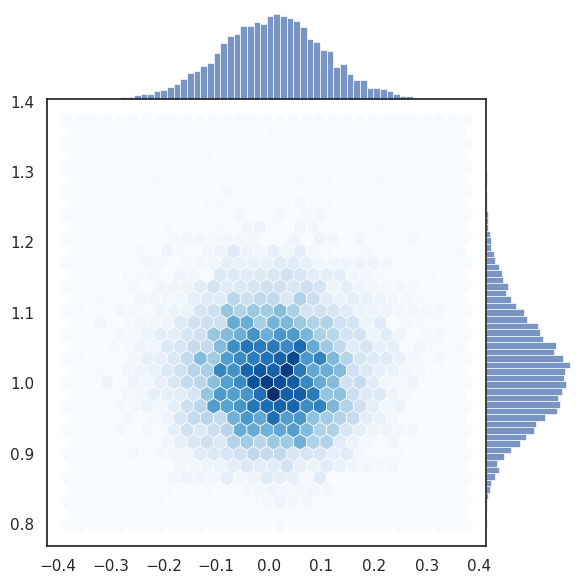

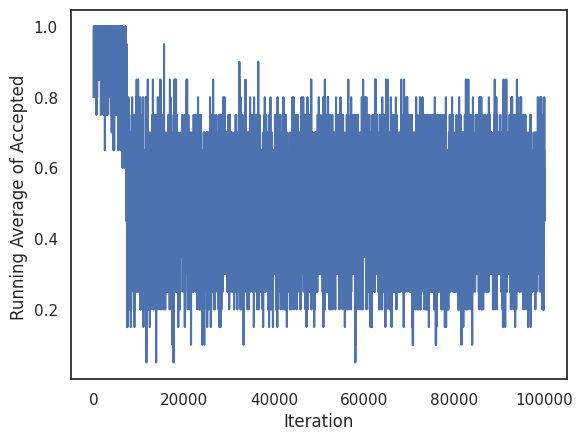

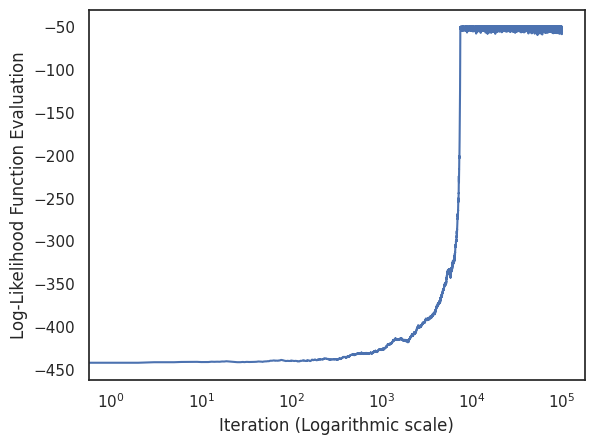

In [96]:
stepsize_rwmh_std = 0.1
lkhd_scaler_rwmh_std = 100
num_iterations_long = 10**5
initial_theta_long = np.array([50,50])
burn_in_long = 10000
samples, accepted, acceptence_prob, lkhd, lkhd_diff = RWMH(data_std, lkhd_std, initial_theta_long, num_iterations_long, stepsize_rwmh_std, lkhd_scaler_rwmh_std)
print("SUCCESFULLY RAN long RWMH")


plot_samples = create_sample(samples, burn_in_long,gap_length)

plt_samples(plot_samples, "rwmh_long_samples")

plot_accepted(accepted,window_size, "rwmh_long_accepted")

plot_lkhd(lkhd, "rwmh_long_lkhd")

### Std

SUCCESFULLY RAN RWMH


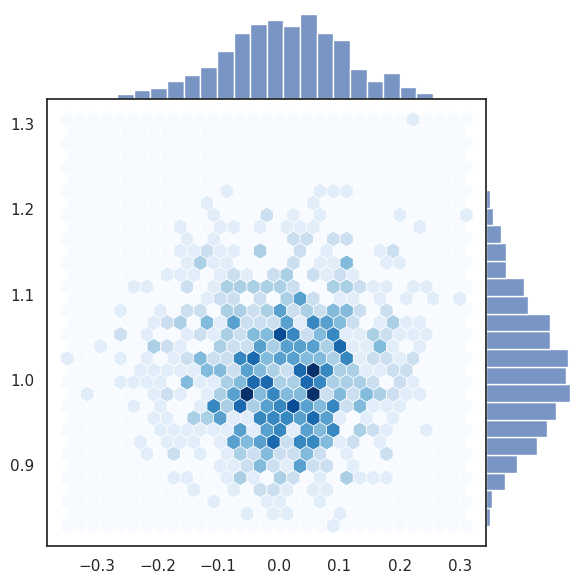

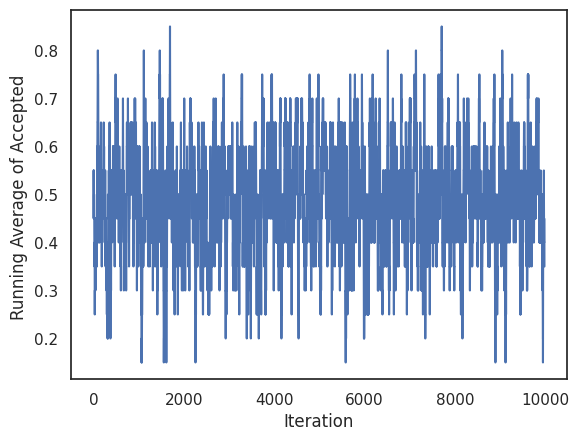

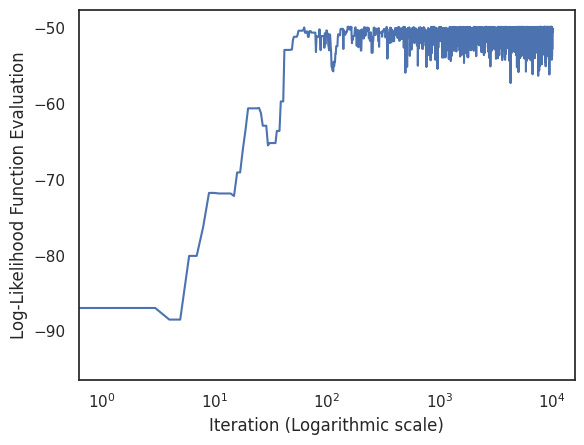

In [89]:
stepsize_rwmh_std = 0.1
lkhd_scaler_rwmh_std = 100
samples, accepted, acceptence_prob, lkhd, lkhd_diff = RWMH(data_std, lkhd_std, initial_theta_std, num_iterations, stepsize_rwmh_std, lkhd_scaler_rwmh_std)
print("SUCCESFULLY RAN RWMH")


plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "rwmh_std")

plot_accepted(accepted,window_size)

plot_lkhd(lkhd)

### Bimod

SUCCESFULLY RAN RWMH


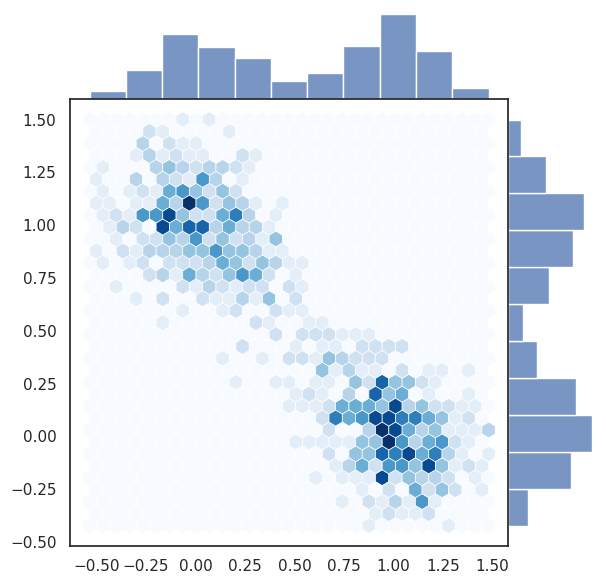

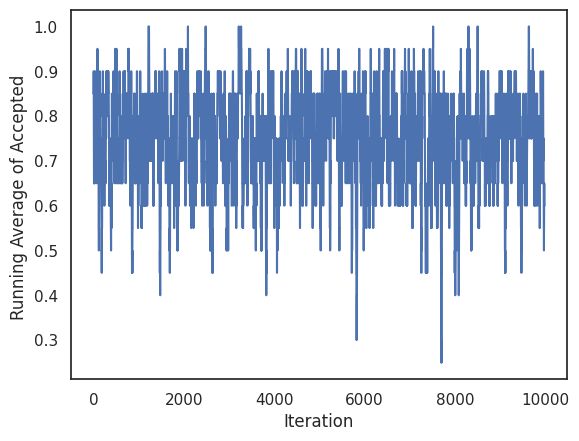

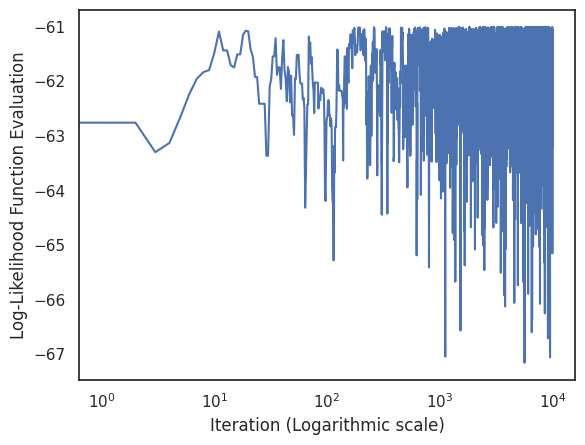

In [72]:
stepsize_rwmh_bi = 0.1
lkhd_scaler_rwmh_bi = 100
samples, accepted, acceptence_prob, lkhd, lkhd_diff = RWMH(data_bi, lkhd_bi, initial_theta_bi, num_iterations, stepsize_rwmh_bi, lkhd_scaler_rwmh_bi)
print("SUCCESFULLY RAN RWMH")

plot_samples = create_sample(samples, burn_in,gap_length)
plt_samples(plot_samples, "rwmh_bi")
plot_accepted(accepted,window_size)
plot_lkhd(lkhd)

## MALA


### Std

SUCCESFULLY RAN MALA
-0.5041953457789623
0.4960056919435716


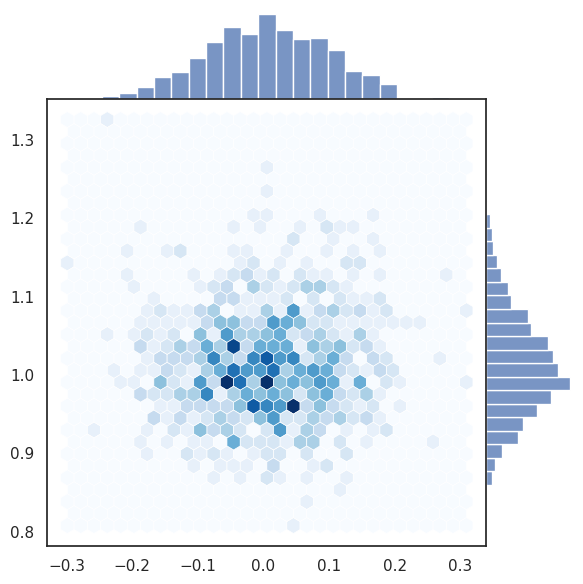

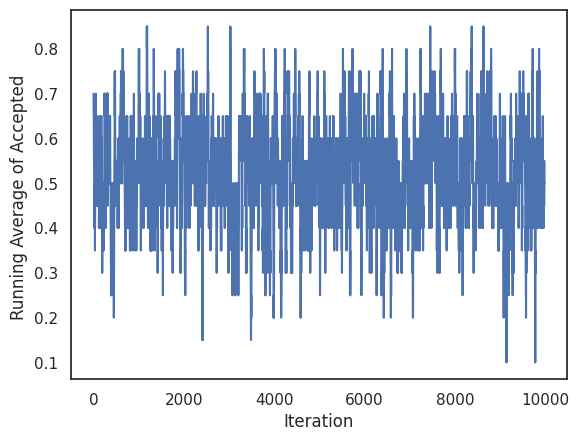

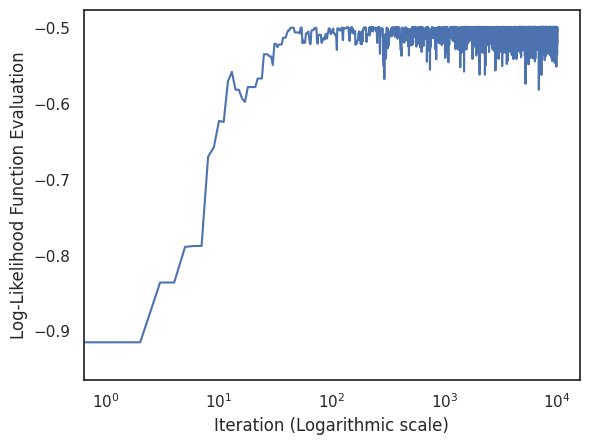

In [73]:
stepsize_mala_std = 0.1
lkhd_scaler_mala_std = 100
samples, accepted, acceptence_prob, lkhd = mala(data_std, lkhd_std, initial_theta_std, num_iterations, stepsize_mala_std, gradient_scaler, lkhd_scaler_mala_std)
print("SUCCESFULLY RAN MALA")
print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "mala_std")
plot_accepted(accepted, window_size)
plot_lkhd(lkhd)

### Bimod

SUCCESFULLY RAN MALA


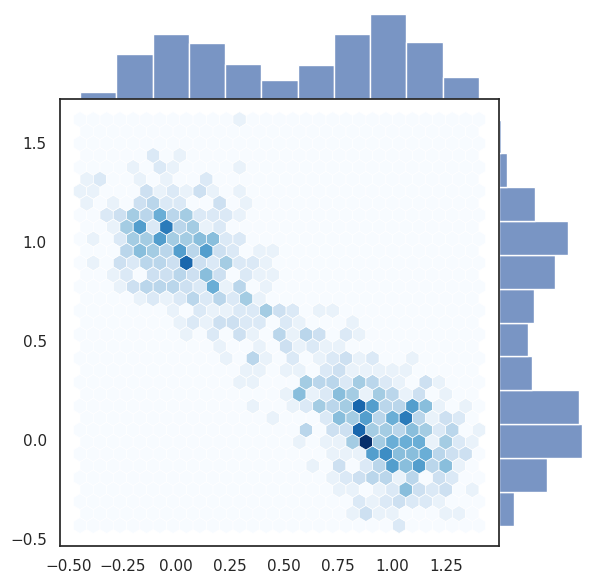

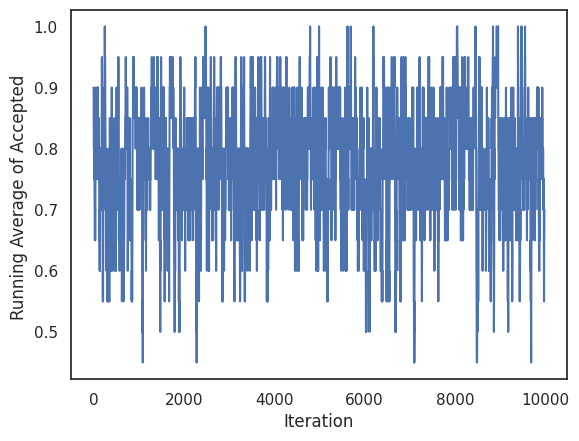

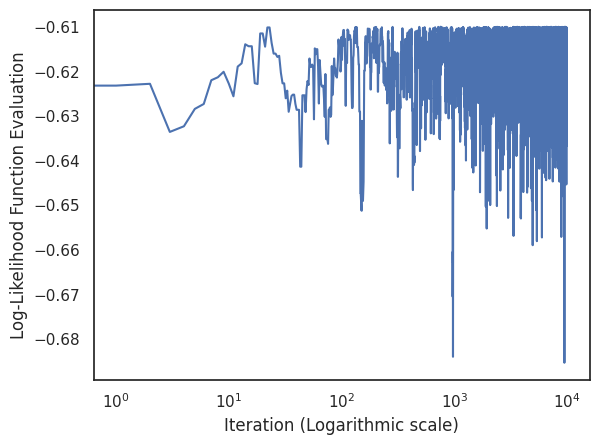

In [92]:
stepsize_mala_bi = 0.1
lkhd_scaler_mala_bi = 100
gradient_scaler_mala_bi = 0.1
samples, accepted, acceptence_prob, lkhd = mala(data_bi, lkhd_bi, initial_theta_bi, num_iterations, stepsize_mala_bi, gradient_scaler_mala_bi, lkhd_scaler)
print("SUCCESFULLY RAN MALA")

plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "mala_bi")
plot_accepted(accepted, window_size)
plot_lkhd(lkhd)

## consensusMC

### Std

SUCCESFULLY RAN consensusMC


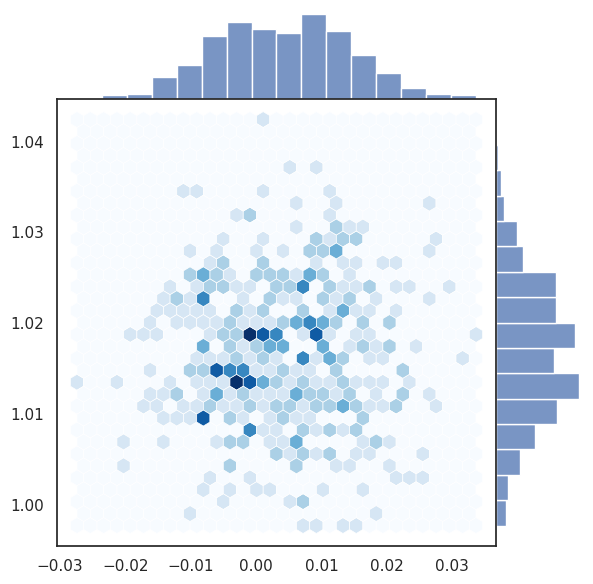

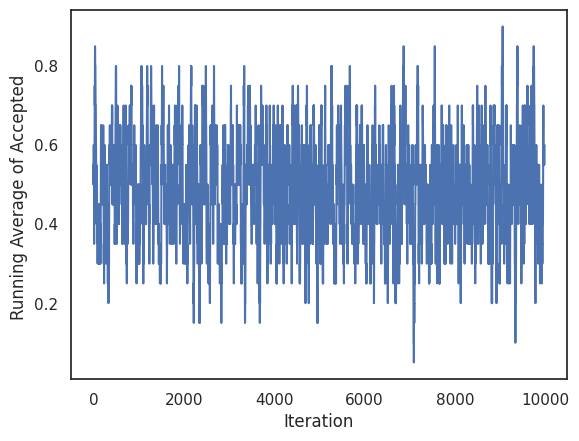

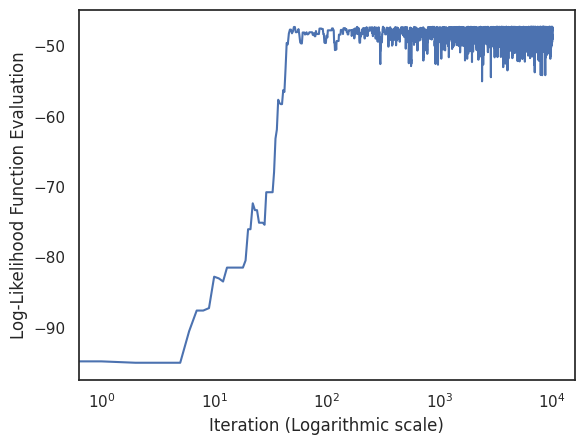

In [75]:
stepsize_consensus_std = 0.1

num_batches_std = 100
lkhd_scaler_consensus_std = 100
samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data_std, lkhd_std, initial_theta_std, num_iterations, stepsize_consensus_std, num_batches_std, lkhd_scaler_consensus_std)
print("SUCCESFULLY RAN consensusMC")

plot_samples = create_sample(samples, burn_in,window_size)

plt_samples(plot_samples, "consensus_std")

plot_accepted(accepted,window_size)

plot_lkhd(lkhd)

### Bimod

SUCCESFULLY RAN consensusMC


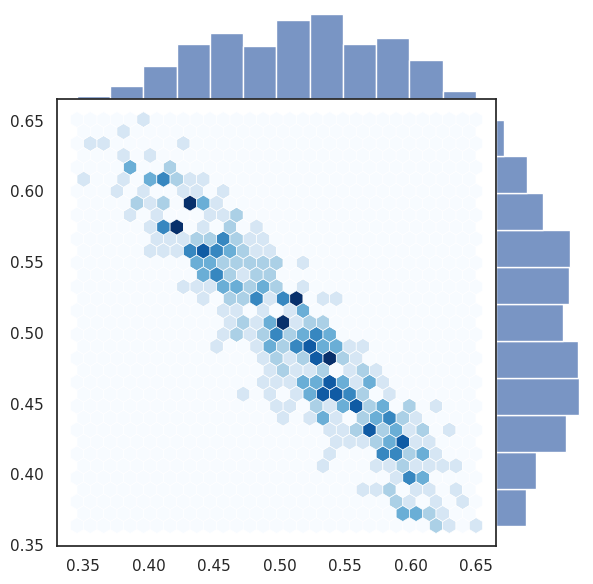

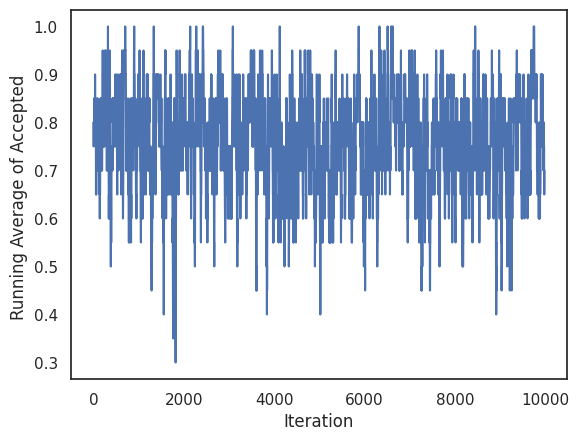

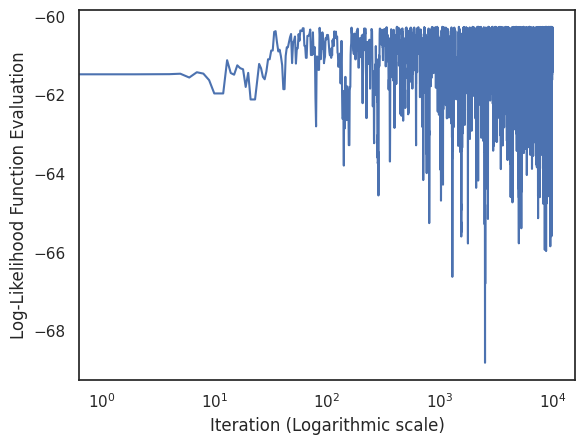

In [76]:
stepsize_rwmh_bi = 0.1
num_batches_bi = 100
lkhd_scaler_consensus_bi = 100

samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data_bi, lkhd_bi, initial_theta_bi, num_iterations, stepsize_rwmh_bi, num_batches_bi, lkhd_scaler_consensus_bi)
print("SUCCESFULLY RAN consensusMC")

plot_samples = create_sample(samples, burn_in,window_size)

plt_samples(plot_samples, "consensus_bi")

plot_accepted(accepted,window_size)

plot_lkhd(lkhd)

## PMMH

### Std

SUCCESFULLY RAN PMMH


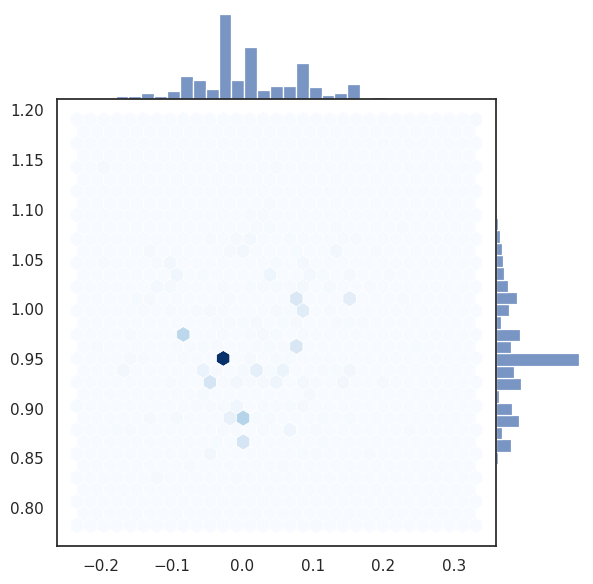

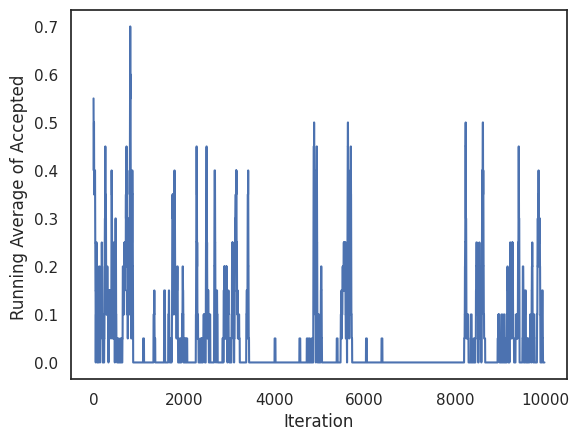

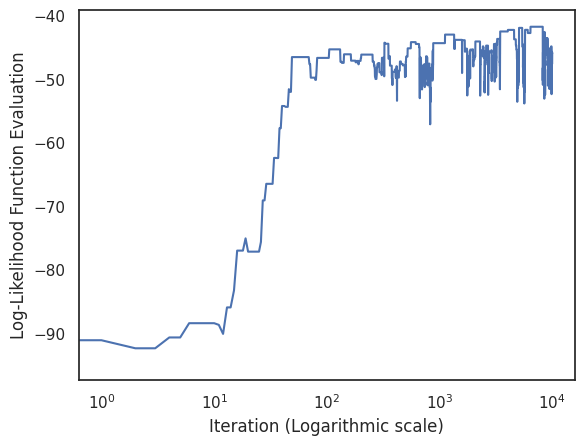

In [77]:
stepsize_pmmh_std = 0.1
lkhd_scaler_pmmh_std = 100
subsampling_perc_pmmh_std = 0.01
samples, accepted, acceptence_prob, lkhd, lkhd_diff = PMMH(data_std, lkhd_std, initial_theta_std, num_iterations, stepsize_pmmh_std, lkhd_scaler_pmmh_std, subsampling_perc_pmmh_std)
print("SUCCESFULLY RAN PMMH")


plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "pmmh_std")

plot_accepted(accepted,window_size)

plot_lkhd(lkhd)

### Bimod

SUCCESFULLY RAN RWMH


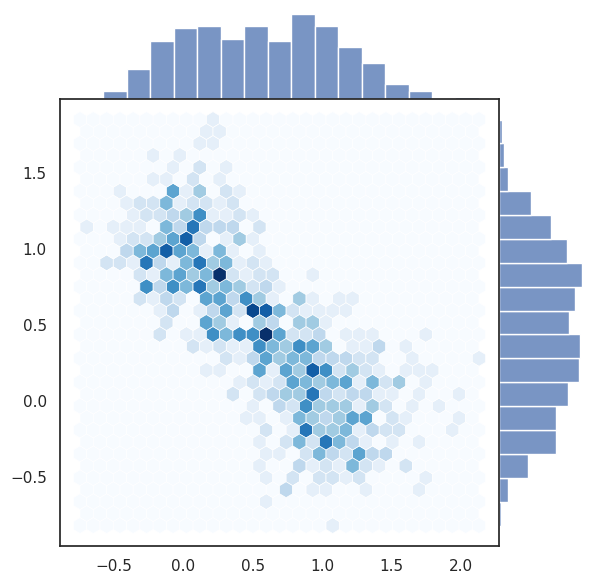

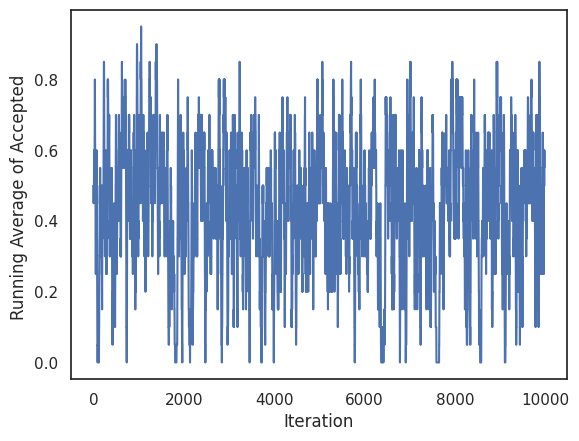

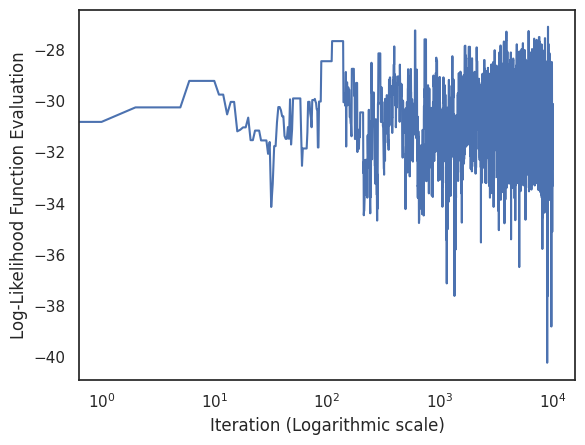

In [78]:
stepsize_pmmh_bi = 0.1
lkhd_scaler_pmmh_bi = 50
subsampling_perc_pmmh_bi = 0.01
samples, accepted, acceptence_prob, lkhd, lkhd_diff = PMMH(data_bi, lkhd_bi, initial_theta_bi, num_iterations, stepsize_pmmh_bi, lkhd_scaler_pmmh_bi, subsampling_perc_pmmh_bi)
print("SUCCESFULLY RAN RWMH")

plot_samples = create_sample(samples, burn_in,gap_length)
plt_samples(plot_samples, "pmmh_bi")
plot_accepted(accepted,window_size)
plot_lkhd(lkhd)

## csMALA

### Std

SUCCESFULLY RAN csMALA


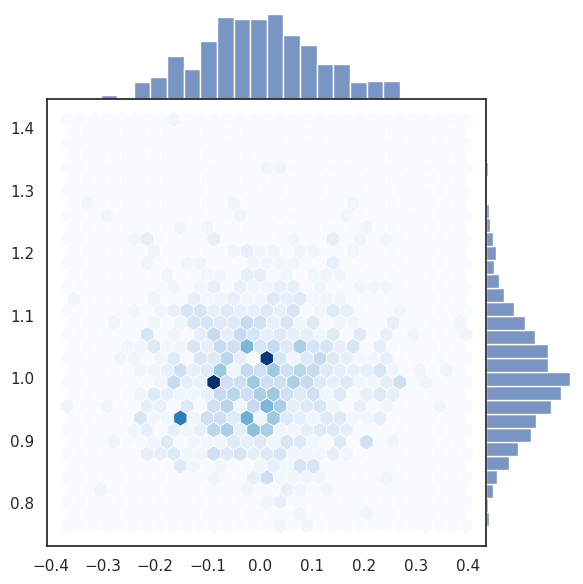

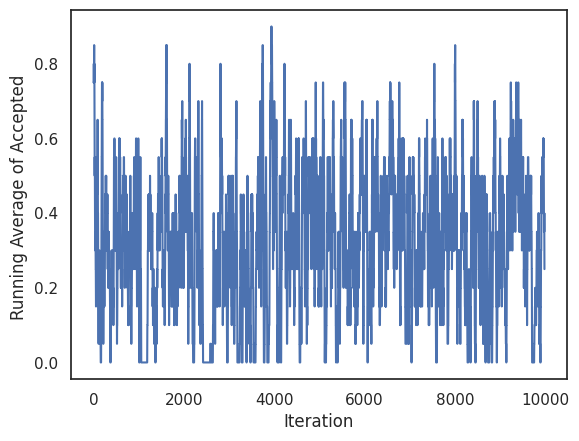

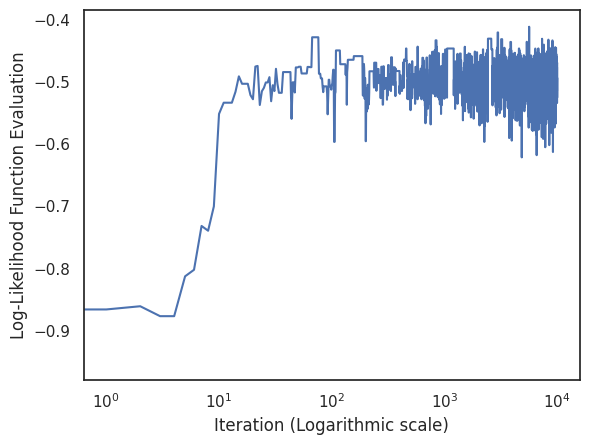

In [79]:
correction_scaler_std = 0.1
lkhd_scaler_csMALA_std = 50
subsampling_perc_csMALA_std = 0.01

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data_std, lkhd_std, initial_theta_std, num_iterations, stepsize_mala_std, gradient_scaler, subsampling_perc_csMALA_std, correction_scaler_std,lkhd_scaler_csMALA_std)
print("SUCCESFULLY RAN csMALA")
plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "csMALA_std")

plot_accepted(accepted, window_size)

plot_lkhd(lkhd)

### Bimod

SUCCESFULLY RAN csMALA


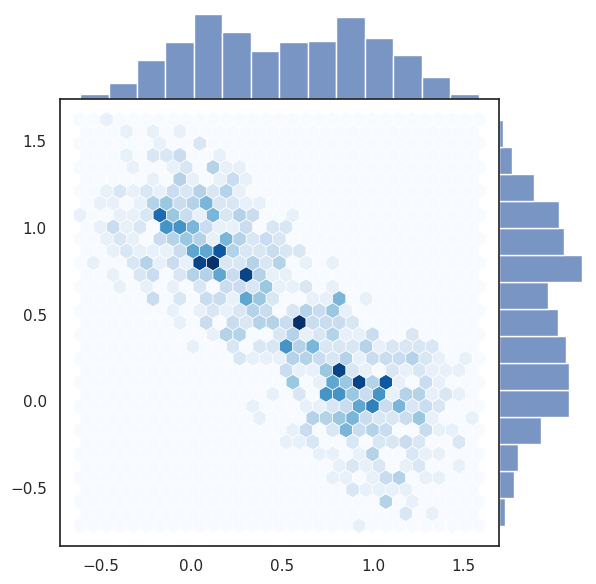

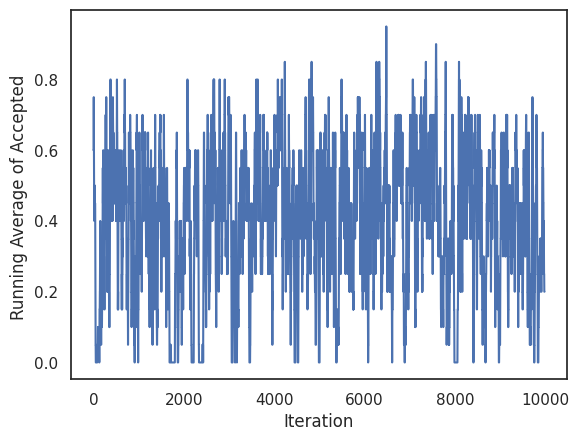

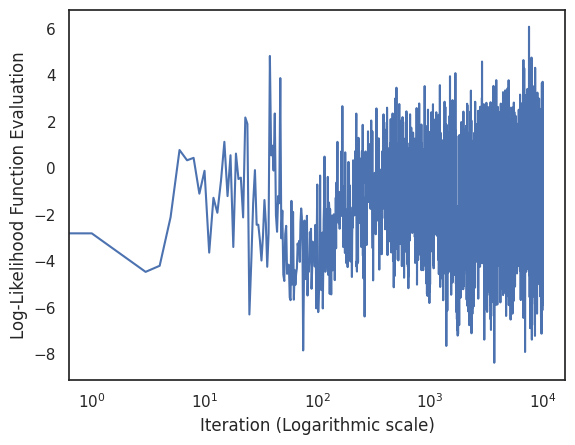

In [80]:
correction_scaler_bi = 0.1
lkhd_scaler_csMALA_bi = 50
subsampling_perc_csMALA_bi = 0.01

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data_bi, lkhd_bi, initial_theta_bi, num_iterations, stepsize_mala_bi, gradient_scaler, subsampling_perc_csMALA_bi, correction_scaler_bi,lkhd_scaler_csMALA_bi)
print("SUCCESFULLY RAN csMALA")
plot_samples = create_sample(samples, burn_in,gap_length)

plt_samples(plot_samples, "csMALA_bi")

plot_accepted(accepted, window_size)

plot_lkhd(lkhd_diff)